In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
from tqdm import tqdm_notebook as tqdm
import math
import cv2 as cv

In [7]:
class PreProc:
    def __init__(self):
        (self.trainx,self.trainy),(self.testx, self.testy) = fashion_mnist.load_data()
        
    def visualize(self,n):
        for i in range(n):
            plt.subplot(330+1+i) # ask someone why??
            plt.imshow(self.trainx[i], cmap = plt.get_cmap('gray'))
        plt.show()
            
        
    def flattenAndCentralize(self):
        trainx_flattened = np.copy(self.trainx).astype('float64')
        testx_flattened = np.copy(self.testx).astype('float64')
        trainx_flattened -= np.mean(trainx_flattened, axis = 0)
        testx_flattened -= np.mean(testx_flattened, axis = 0)
        for image in trainx_flattened:
            image = cv.GaussianBlur(image,(3,3),cv.BORDER_DEFAULT)
        trainx_flattened.shape = (len(trainx_flattened),784)
        testx_flattened.shape = (10000,784)
        return trainx_flattened,testx_flattened
    

    
    def getLabels(self):
        return self.trainy, self.testy
    
    def getInputSize(self):
        return len(self.trainx[0])

In [44]:
class Functions:
    @staticmethod
    def sigmoid(input):
        input = np.clip(input, -100,100)
        return  1.0/(1.0+np.exp(-input))
    
    @staticmethod
    def reLU(input):
        return np.maximum(np.random.randint(low=1, high=10)*1e-5, input)
    
    @staticmethod
    def tanh(input):
        return np.tanh(input)
    
    @staticmethod
    def identity(input):
        return input
    
    @staticmethod
    def softmax(input):
        input = np.clip(input, -100,100)
        return np.exp(input)/(np.sum(np.exp(input)))
    
    @staticmethod
    def onehot(input):
        result = np.zeros(10)
        result[input] = 1
        return result
    
    @staticmethod
    def crossEntropyLoss(y,yHat):
        loss = (-1/10.0) * np.sum(np.multiply(y, np.log(yHat+1e-10)) + np.multiply((1 - y), np.log(1 - (yHat+1e-10))))
        return loss
    
    @staticmethod
    def derivative_sigmoid(input):
        return Functions.sigmoid(input)*(1-Functions.sigmoid(input))
    
    @staticmethod
    def derivative_tanh(input):
        return (1 - (np.tanh(input)**2))
    
    @staticmethod
    def derivative_reLU(input):
        return np.where(input > 0, 1, 0)

    
    @staticmethod
    def derivative_identity(input):
        return 1
    
    @staticmethod
    def plot(input, labely):
        plt.plot(input)
        plt.xlabel(labely)
        plt.ylabel("")
        plt.title(labely +" over iterations")
        plt.show()

In [41]:
np.random.randint(low=1, high=10)*1e-5

8e-05

In [63]:
true = train_y[0]
pred = Algorithms.ForwardProp(weights, biases, Functions.sigmoid, Functions.softmax, trainx[0])
print(pred.shape())

AttributeError: 'tuple' object has no attribute 'shape'

In [46]:
class Algorithms:
    @staticmethod
    def uniLoss(weights, biases, activate, output, trainx, train_y):
        Loss = 0.0
        for index in range(len(trainx)):
            a,h = Algorithms.ForwardProp(weights, biases, activate, output, trainx[index])
            pred = h[-1]
            true = train_y[index]
            Loss += Functions.crossEntropyLoss(true, pred)
        return Loss
    
    @staticmethod
    def ForwardProp(weights, bias, activate, output, inputLayer):
        L = len(weights)-1
        a = []
        h = []
        a.append(np.matmul(weights[0],inputLayer)+bias[0])
        h.append(activate(a[0]))
        for k in range(1,L):
            a.append(np.matmul(weights[k],h[k-1].T)+bias[k])
            h.append(activate(a[k]))
        a.append(np.matmul(weights[L],h[L-1].T)+bias[L])
        h.append(output(a[L]))
        return a,h
    
    @staticmethod
    def BackProp(weights, biases, a, h, derivative, dataPoint, dataLabel):
        L = len(weights)-1
        gradaL = -(Functions.onehot(dataLabel)-h[len(h)-1])
        dw = np.zeros_like(weights)
        db = np.zeros_like(biases)
        for k in range(L,0,-1):
            gradW = np.outer(gradaL, h[k-1].T)
            gradB = gradaL
            dw[k] = gradW
            db[k] = gradB

            gradhL_1 = np.matmul(np.transpose(weights[k]),gradaL)
            gradaL_1 = np.multiply(gradhL_1, derivative(a[k-1]))
            gradaL = gradaL_1
        dw[0] = np.outer(gradaL,dataPoint.T)
        db[0] = gradaL
        return dw, db

    @staticmethod
    def miniBatchMGD(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        lossTrack = []
        validation = []
        validationLoss = []
        trainAccuracy = []
        LOSS = 0.0
        beta = 0.9
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights, biases , activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases, a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                momentumWeights = prevWeights*beta + dw*1.0
                momentumBiases = prevBiases*beta + db*1.0
                weights -= learningRate*(momentumWeights + decay*weights)
                biases -= learningRate*(momentumBiases + decay*biases)
                prevWeights = momentumWeights
                prevBiases = momentumBiases
                lossTrack.append(batchLoss)
                
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("training Accuracy: "+str(trainAccuracy[-1]))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return weights, biases

    @staticmethod
    def ADAM(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        prev_val = 0.0
        beta1 = 0.9
        beta2 = 0.99
        epsilon = 0.000001
        patience = 3
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        m_w = np.zeros_like(weights)
        v_w = np.zeros_like(weights)
        m_b = np.zeros_like(biases)
        v_b = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        i = 0
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.ceil(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights, biases,activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases , a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                m_w = beta1*m_w + (1-beta1)*dw
                m_b = beta1*m_b + (1-beta1)*db
                v_w = v_w*beta2 + (1-beta2)*dw**2
                v_b = v_b*beta2 + (1-beta2)*db**2
                
                m_w_hat = m_w/(1 - np.power(beta1, i+1))
                m_b_hat = m_b/(1 - np.power(beta1, i+1))
                v_w_hat = v_w/(1 - np.power(beta2, i+1))
                v_b_hat = v_b/(1 - np.power(beta2, i+1))
                
                i+=1
                
                tempW = np.zeros_like(m_w)
                tempB = np.zeros_like(m_b)
                for i in range(len(dw)):
                    tempW[i] = np.sqrt(v_w_hat[i])
                    tempB[i] = np.sqrt(v_b_hat[i])
                weights = weights - ((learnerRateW*(dw + decay*weights))/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)

                lossTrack.append(batchLoss)
                
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("validation accuracy: " + str(validation[-1]))
            print(validation[-1])
            if validation[-1] <= prev_val+1e-2:
                patience -= 1
            else:
                patience = 3
                prev_weights = weights
                prev_biases = biases
                prev_val = validation[-1]
            
            if patience == 0:
                weights = prev_weights
                biases = prev_biases
        if prev_val > validation[-1]:
            Functions.plot(loss, "loss")
            Functions.plot(validation, "validation accuracy")
            Functions.plot(validationLoss, "validation loss")
            Functions.plot(trainAccuracy, "train accuracy")
            return prev_weights, prev_biases
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return weights,biases

    @staticmethod
    def NADAM(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        patience = 3
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        prev_val = 0.0
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        beta1 = 0.9
        beta2 = 0.99
        epsilon = 0.000001
        prev_weights = np.zeros_like(weights)
        prev_biases = np.zeros_like(biases)
        m_w = np.zeros_like(weights)
        v_w = np.zeros_like(weights)
        m_b = np.zeros_like(biases)
        v_b = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        i = 0
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.ceil(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights - v_w*(beta1), biases - v_b*(beta1), activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights - v_w*(beta1), biases - v_b*(beta1), a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                m_w = beta1*m_w + (1-beta1)*dw
                m_b = beta1*m_b + (1-beta1)*db
                v_w = v_w*beta2 + (1-beta2)*dw**2
                v_b = v_b*beta2 + (1-beta2)*db**2
                
                m_w_hat = m_w/(1 - np.power(beta1, i+1))
                m_b_hat = m_b/(1 - np.power(beta1, i+1))
                v_w_hat = v_w/(1 - np.power(beta2, i+1))
                v_b_hat = v_b/(1 - np.power(beta2, i+1))
                
                i+=1
                
                tempW = np.zeros_like(m_w)
                tempB = np.zeros_like(m_b)
                for j in range(len(dw)):
                    tempW[j] = np.sqrt(v_w_hat[j])
                    tempB[j] = np.sqrt(v_b_hat[j])
                weights = weights - ((learnerRateW*(dw + decay*weights))/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)
                lossTrack.append(batchLoss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            if validation[-1] <= prev_val:
                patience -= 1
            else:
                patience = 3
                prev_weights = weights
                prev_biases = biases
                prev_val = validation[-1]
            
            if patience <= 0:
                weights = prev_weights
                biases = prev_biases
            print("validation accuracy: " + str(validation[-1]))

            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("validation accuracy: " + str(validation[-1]))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return prev_weights, prev_biases

    
    @staticmethod
    def miniBatchNAG(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        beta = 0.9
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                tempWeights = np.zeros_like(weights)
                tempBiases = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights-prevWeights, biases-prevBiases, activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights-prevWeights, biases-prevBiases, a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    tempWeights += currWeights
                    tempBiases += currBiases
                batchLoss /= batchSize
                tempWeights /= batchSize
                tempBiases /= batchSize
                momentumWeights = beta*prevWeights + tempWeights*1.0
                momentumBiases = beta*prevBiases + tempBiases*1.0
                weights = weights - learningRate*(momentumWeights + decay*weights) 
                biases = biases - learningRate*(momentumBiases + decay*biases)
                prevWeights = momentumWeights
                prevBiases = momentumBiases
                lossTrack.append(batchLoss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("validation accuracy: " + str(validation[-1]))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return weights, biases
    
    @staticmethod
    def RMSProp(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        beta = 0.5
        epsilon = 0.000001
        momentumWeights = np.zeros_like(weights)
        momentumBiases = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights, biases, activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases , a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                momentumWeights = momentumWeights*beta + (1-beta)*dw**2
                momentumBiases = momentumBiases*beta + (1-beta)*db**2
                tempW = np.zeros_like(momentumWeights)
                tempB = np.zeros_like(momentumBiases)
                for i in range(len(dw)):
                    tempW[i] = np.sqrt(momentumWeights[i])
                    tempB[i] = np.sqrt(momentumBiases[i])
                weights = weights - ((learnerRateW)*(dw + decay*weights)/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)
                lossTrack.append(batchLoss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("validation accuracy: " + str(validation[-1]))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
            #pbar.set_description("validation Accuracy: " + str(validation[-1]))
        return weights, biases

    @staticmethod
    def miniBatchGD(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            Loss = 0.0
            for i in range(math.ceil(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights, biases , activate, output, trainer[data])
                    tempw,tempb = Algorithms.BackProp(weights, biases, a, h, derivative, trainer[data], labeler[data])
                    dw+=tempw
                    db+=tempb
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                Loss += batchLoss
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                weights -= learningRate*(dw + decay*weights)
                biases -= learningRate*(db + decay*biases)
                lossTrack.append(batchLoss)
            Loss /= len(dataPoints)
            loss.append(Loss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        
           
        return weights, biases
    
    @staticmethod
    def evaluateNetwork(weights, biases,activate, output, test_x, test_y):
        num_acc = 0
        for i in range(len(test_x)):
            a,h = Algorithms.ForwardProp(weights, biases, activate, output, test_x[i])
            h = np.array(h, dtype = object)
            predY =   np.argmax(h[len(h)-1])
            if test_y[i] == predY:
                num_acc+=1
        return (num_acc/len(test_y))

In [47]:
!jt -t monokai

/var/folders/hm/9gm9jdm90q5fz1jnmjxxsxh40000gn/T/ipykernel_10521/2800292977.py:213: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/5 [00:00<?, ?it/s]

validation accuracy: 0.8231666666666667
validation accuracy: 0.8231666666666667
validation accuracy: 0.8486666666666667
validation accuracy: 0.8486666666666667
validation accuracy: 0.8583333333333333
validation accuracy: 0.8583333333333333
validation accuracy: 0.866
validation accuracy: 0.866
validation accuracy: 0.871
validation accuracy: 0.871


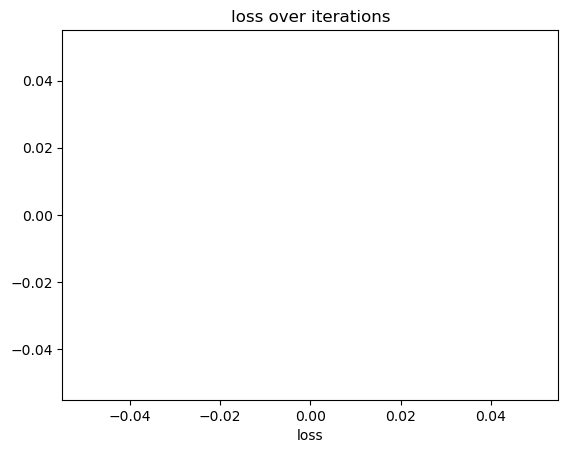

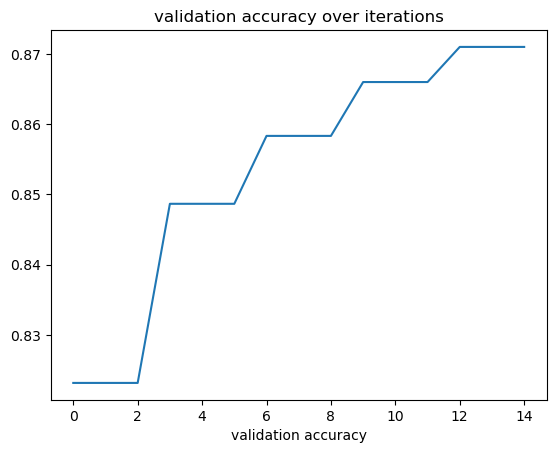

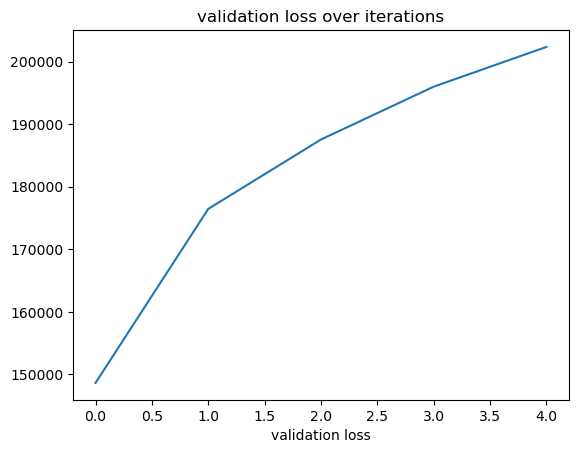

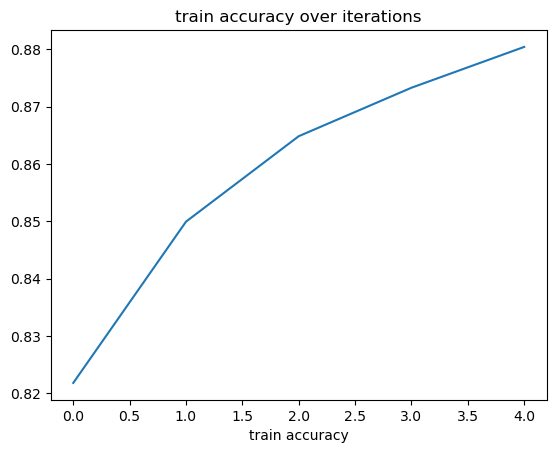

0.8588


In [47]:
if __name__ == '__main__':
    data = PreProc()
    #data.visualize(5)
    train_x, test_x = data.flattenAndCentralize()
    trainx = train_x/255.0
    testx = test_x/255.0
    train_y, test_y = data.getLabels()
    neuralNet = FFNet(0, len(trainx[0]), 10)

    neuralNet.addHiddenLayer(64, "xavier")
    neuralNet.addHiddenLayer(64, "xavier")#drastic decrease in accuracy
    neuralNet.addHiddenLayer(64, "xavier")#drastic decrease in accuracy
    neuralNet.addHiddenLayer(64, "xavier")#drastic decrease in accuracy
    neuralNet.addOutputLayer(10, "xavier")
    neuralNet.solidify()
    #print(trainx.shape)
    #wandb.init()
    weights,biases = neuralNet.fit("nadam",64, 0.001, "sigmoid", trainx, train_y, 0, 5)
    #neuralNet.evaluate()

In [5]:
#The class of FeedForwardNeuralNetwor

class FFNet:
    #constructor
    def __init__(self,number_of_hidden_layers, number_of_inputs, number_of_outputs):
        self.number_of_inputs = number_of_inputs
        self.number_of_hidden_layers = number_of_hidden_layers
        self.number_of_outputs = number_of_outputs
        self.input = [0 for i in range(number_of_inputs)]
        self.output = [0 for i in range(10)]
        self.weights = []
        self.biases = []
        #self.hidden.append(np.random.random((number_of_inputs+1)))
    
    #Method for creating layers
    def addHiddenLayer(self,number_of_neurons, initialization):
        if(len(self.weights) == 0):
            temp_weights = np.random.randn(number_of_neurons, self.number_of_inputs)*0.01
            temp_biases = np.full((number_of_neurons), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_neurons, self.number_of_inputs)/np.sqrt((self.number_of_inputs)/2)
                #temp_biases = np.random.randn(number_of_neurons)*np.sqrt(1/(number_of_neurons))
        else:
            prev_neurons = len(self.weights[-1])
            temp_weights = np.random.randn(number_of_neurons, prev_neurons)*0.01
            temp_biases = np.full((number_of_neurons), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_neurons, prev_neurons)/np.sqrt((prev_neurons)/2)
                #temp_biases = np.random.randn(number_of_neurons)*np.sqrt(1/(number_of_neurons))

        self.weights.append(temp_weights)
        self.biases.append(temp_biases)
    
    def addOutputLayer(self, number_of_outputs, initialization):
        if(len(self.weights) == 0):
            #print("number of inputs: "+str(self.number_of_inputs))
            temp_weights = np.random.randn(number_of_outputs, self.number_of_inputs)*0.01
            temp_biases = np.full((number_of_outputs), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_outputs, self.number_of_inputs)/np.sqrt((prev_neurons)/2)
        else:
            prev_neurons = len(self.weights[-1])
            temp_weights = np.random.randn(number_of_outputs, prev_neurons)*0.01
            temp_biases = np.full((number_of_outputs), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_outputs, prev_neurons)/np.sqrt((prev_neurons)/2)
                
        
        self.weights.append(temp_weights)
        self.biases.append(temp_biases)

    def solidify(self):
        self.weights = np.array(self.weights, dtype = object)
        self.biases = np.array(self.biases, dtype = object)

    def getNetwork(self):
        return self.weights,self.biases
    
    def ForwardProp(self, activate, output, inputLayer):
        return Algorithms.ForwardProp(self.network, activate, output, inputLayer)
    
    def lossCalc(self, lossFunction, Y):
        predY = self.historyA[(len(self.historyA)-1)]
        return lossFunction(Y,self.predY)

    def BackProp(self, a, h, dataPoint, dataLabel):
        return Algorithms.BackProp(self.network, a, h, dataPoint, dataLabel)
    
    def fit(self, optimizer, batchSize, learningRate, activation, trainx, train_y, decay, epochs):
        
        #break data into training and validation
        indices = np.arange(len(trainx))
        np.random.shuffle(indices)
        trainx = trainx[indices]
        train_y = train_y[indices]
        
        valTest_x = trainx[int(0.9*len(trainx)):]
        valTest_y = train_y[int(0.9*len(train_y)):]
        
        trainx = trainx[:int(0.9*len(trainx))]
        train_y = train_y[:int(0.9*len(train_y))]
        
        if activation == "relu":
            activate = Functions.reLU
            derivative = Functions.derivative_reLU
            output = Functions.softmax
        elif activation == "tanh":
            activate = Functions.tanh
            derivative = Functions.derivative_tanh
            output = Functions.softmax
        elif activation == "identity":
            activate = Functions.identity
            derivative = Functions.derivative_identity
            output = Functions.softmax
        else:
            activate = Functions.sigmoid
            derivative = Functions.derivative_sigmoid
            output = Functions.softmax
        
        #print(optimizer)
        
        if optimizer == "momentum":
            self.weights, self.biases = Algorithms.miniBatchMGD(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "nag":
            self.weights, self.biases = Algorithms.miniBatchNAG(self.weights,self.biases , batchSize, learningRate,activate, output, derivative , trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "rmsprop":
            self.weights, self.biases = Algorithms.RMSProp(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "adam":
            self.weights, self.biases = Algorithms.ADAM(self.weights,self.biases , batchSize, learningRate,activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "nadam":
            self.weights, self.biases = Algorithms.NADAM(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        else:
            self.weights, self.biases = Algorithms.miniBatchGD(self.weights,self.biases , batchSize, learningRate, activate, output, derivative , trainx, train_y, valTest_x, valTest_y, decay, epochs)
        print(Algorithms.evaluateNetwork(self.weights, self.biases, activate, output, testx, test_y))       
        
        return self.weights,self.biases
            
    def evaluateNetwork(self, testx, tes_ty):
        Algorithms.evaluateNetwork(self.weights, self.biases, testx, test_y)        
        